# Time series analysis
_2020.04.26_

In this project you need to prepare a forecast for an imaginary bank of the number of its active customers and total balance for the next 90 days.

## Installation

**fbProphet installation guide**<br/>
First install _Ephem_:

<code>conda install -c anaconda ephem</code>

Install _Pystan_:

<code>conda install -c conda-forge pystan</code>

Finally install _Fbprophet_:

<code>conda install -c conda-forge fbprophet</code>

Then according to [this](https://stackoverflow.com/questions/53178281/installing-fbprophet-python-on-windows-10) article replace line 16 in fbprophet/hdays.py:

<code>from holidays import WEEKEND, HolidayBase, easter, rd</code>

to

<code>from holidays import WEEKEND, HolidayBase
from dateutil.easter import easter
from dateutil.relativedelta import relativedelta as rd</code>

## Import

In [1]:
import math

import warnings
import matplotlib

from datetime import date
from datetime import datetime, timedelta

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from fbprophet import Prophet
from fbprophet.plot import plot
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

from keras.layers import LSTM
from keras.layers import Dense
from keras.models import Sequential

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

warnings.filterwarnings("ignore")

style.use('seaborn-poster')
style.use('ggplot')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Using TensorFlow backend.


In [2]:
def reduce_memory_usage(df, verbose=True): 
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] 
    start_mem = df.memory_usage().sum() / 1024**2 
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns: 
        col_type = df[col].dtypes 
        if col_type in numerics: 
            c_min = df[col].min() 
            c_max = df[col].max() 
            if str(col_type)[:3] == 'int': 
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max: 
                    df[col] = df[col].astype(np.int8) 
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max: 
                    df[col] = df[col].astype(np.int16) 
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max: 
                    df[col] = df[col].astype(np.int32) 
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max: 
                    df[col] = df[col].astype(np.int64)   
                else: 
                    if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max: 
                        df[col] = df[col].astype(np.float16) 
                    elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max: 
                        df[col] = df[col].astype(np.float32) 
                    else: 
                        df[col] = df[col].astype(np.float64)     
        end_mem = df.memory_usage().sum() / 1024**2 
        if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem)) 
        return df

$MAPE = \frac{\sum \frac{\left | A-F \right |}{A} \times 100}{N}$

$SMAPE = \frac{\sum \frac{\left | A-F \right |}{(|A| + |F|)/2} \times 100}{N}$

In [3]:
def symmetric_mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true)-np.abs(y_pred)/2)))*100

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

## Loading

In [259]:
df_customers = pd.read_csv('data/output_20200426214825.csv', dtype='object', usecols=['date', 'amount_weekly'])

df_customers['date'] = pd.to_datetime(df_customers['date'])
df_customers['amount_weekly'] = pd.to_numeric(df_customers['amount_weekly'].str.replace(',', ''))

df_customers['change'] = df_customers['amount_weekly'].diff()
df_customers.loc[0, 'change'] = 0
df_customers['change'] = pd.to_numeric(df_customers['change'], downcast='integer')

In [260]:
print("{:,} records and {} features in active customer set.".format(df_customers.shape[0], df_customers.shape[1]))
df_customers = reduce_memory_usage(df_customers)

821 records and 3 features in active customer set.
Starting memory usage:  0.02 MB
Reduced memory usage:  0.02 MB (0.0% reduction)


In [261]:
df_customers[:5]

,date,amount_weekly,change
0,2018-01-01,2470.482855,0.000000
1,2018-01-02,2475.139045,4.656190
2,2018-01-03,2479.799767,4.660722
3,2018-01-04,2484.465020,4.665253
4,2018-01-05,2484.451580,-0.013441


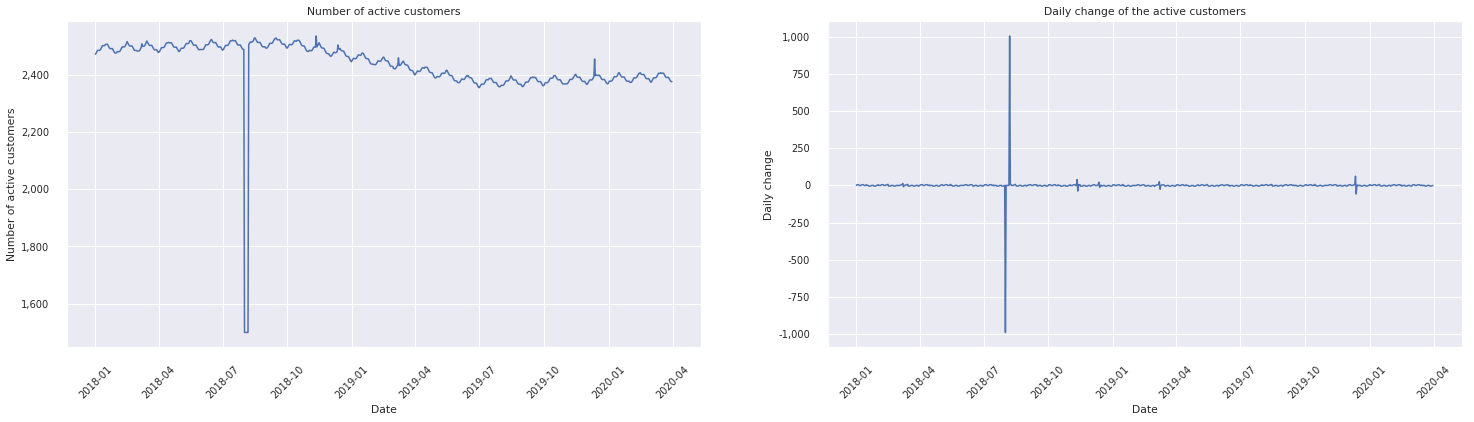

In [262]:
plt.figure(figsize=(25, 6))
sns.set(font_scale=0.9)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x=df_customers['date'], y=df_customers['amount_weekly'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Number of active customers')
ax.set_title('Number of active customers')

plt.subplot(1, 2, 2)
ax = sns.lineplot(x=df_customers['date'], y=df_customers['change'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Daily change')
ax.set_title('Daily change of the active customers')

plt.show()

## Analyses

### fbProphet

In [268]:
df_customers[('2018-07-30' < df_customers['date']) & (df_customers['date'] < '2018-08-08')]

,date,amount_weekly,change
211,2018-07-31,2487.727621,0.172871
212,2018-08-01,1500.000000,-987.727621
213,2018-08-02,1500.000000,0.000000
214,2018-08-03,1500.000000,0.000000
215,2018-08-04,1500.000000,0.000000
216,2018-08-05,1500.000000,0.000000
217,2018-08-06,1500.000000,0.000000
218,2018-08-07,2504.102582,1004.102582


In [270]:
#Interpolate the balance values for January 31th
start = df_customers.loc[df_customers['date']==datetime.strptime('2018-07-30', '%Y-%m-%d'), 'amount_weekly'].values[0]
end = df_customers.loc[df_customers['date']==datetime.strptime('2018-08-08', '%Y-%m-%d'), 'amount_weekly'].values[0]
df_customers.loc[('2018-07-30' < df_customers['date']) & (df_customers['date'] < '2018-08-08'), 'amount_weekly'] = (start + end)/2

In [271]:
#Compute the new daily changes
df_customers['change'] = df_customers['amount_weekly'].diff()
df_customers.loc[0, 'change'] = 0
df_customers['change'] = pd.to_numeric(df_customers['change'], downcast='integer')

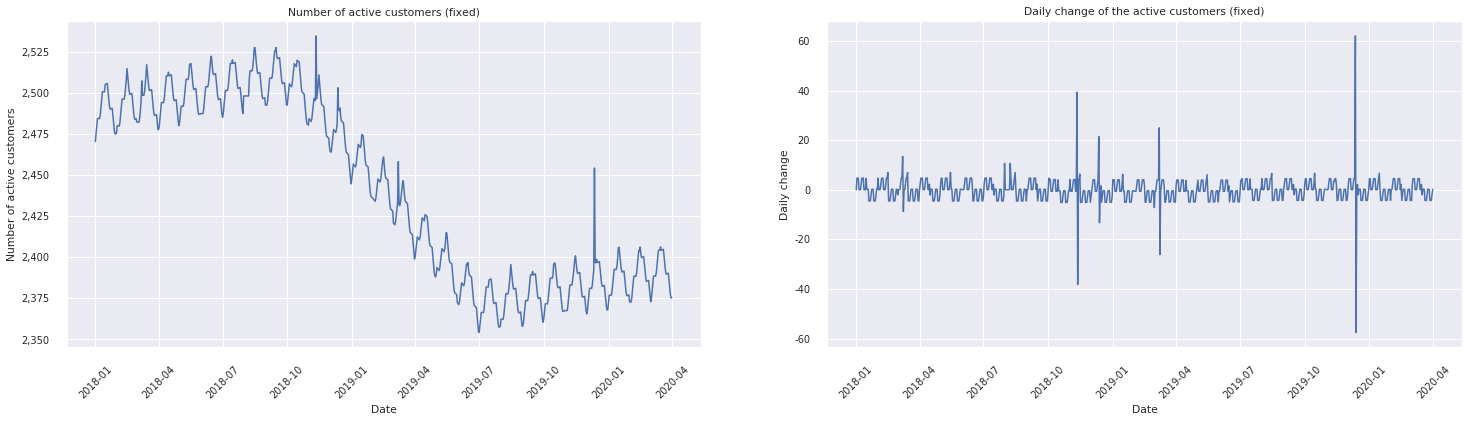

In [273]:
plt.figure(figsize=(25, 6))
sns.set(font_scale=0.9)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x=df_customers['date'], y=df_customers['amount_weekly'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Number of active customers')
ax.set_title('Number of active customers (fixed)')

plt.subplot(1, 2, 2)
ax = sns.lineplot(x=df_customers['date'], y=df_customers['change'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Daily change')
ax.set_title('Daily change of the active customers (fixed)')

plt.show()

In [275]:
#Payment days
pay_days = ['2018-03-08', '2018-11-11', '2018-12-12', '2019-03-08', '2019-11-11', '2019-12-12']
df_customers['pay_day'] = 1*(df_customers['date'].isin([datetime.strptime(d, '%Y-%m-%d') for d in pay_days]))

#Next working day to the pay day
df_customers['prev_date'] = df_customers['date'] - timedelta(days=1)
df_customers['next_to_payday'] = [0]*df_customers.shape[0]

In [277]:
#For this small data set is easier to mark the future days by hand
d1 = datetime.strptime('2020-03-08', '%Y-%m-%d')
d2 = datetime.strptime('2020-11-11', '%Y-%m-%d')
df_customers.loc[df_customers['date'].isin([d1, d2]), 'next_to_payday'] = 1

In [278]:
df_customers.rename(columns={'date': 'ds', 'change': 'y'}, inplace=True)
m = Prophet(seasonality_mode='multiplicative', yearly_seasonality=False, daily_seasonality=False, interval_width=0.95) #It already has a weekly seasonality
m.add_seasonality(name='monthly', period=30.5, fourier_order=4) #Add monthly seasonality
m.add_country_holidays(country_name='ID') #Public holidays
m.add_regressor('pay_day') #Pay days
m.add_regressor('next_to_payday') #Next working day to pay days
m.fit(df_customers)

In [280]:
future = m.make_future_dataframe(periods=90)

#Add the payment days to the future dataframe
future['pay_day'] = 1*(future['ds'].isin([datetime.strptime(d, '%Y-%m-%d') for d in pay_days]))

#Add the next working day to the payment days
future['next_to_payday'] = [df_customers[df_customers['ds']==d]['next_to_payday'].values[0] if d < datetime.strptime('2019-02-25', '%Y-%m-%d') else 0 for d in future['ds']]

# Add future next working days
future_next2payday_list = ['2018-05-28', '2019-02-26', '2019-03-26', '2019-04-26', '2019-05-27', '2019-06-26', '2019-07-26', '2019-08-26', '2019-09-26', '2019-10-28', '2019-11-26', '2019-12-24']

for i in future_next2payday_list:
    future.loc[future['ds'] == datetime.strptime(i, '%Y-%m-%d'), 'next_to_payday'] = 1

In [281]:
forecast = m.predict(future)

[[<matplotlib.lines.Line2D at 0x7f42caab6390>],

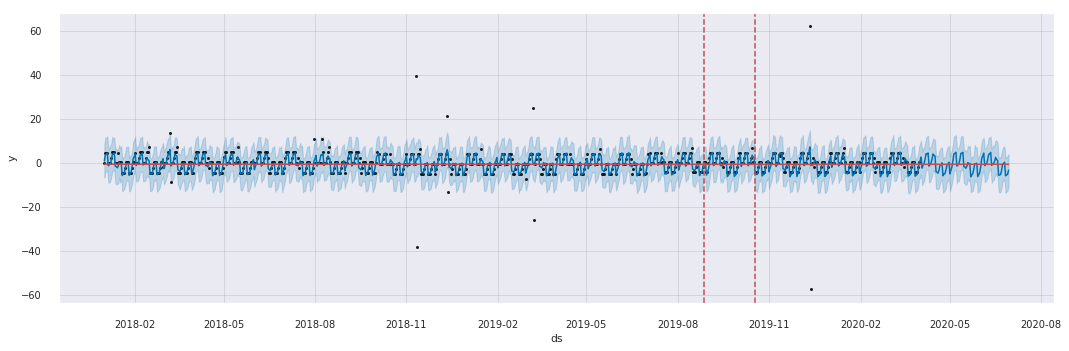

In [282]:
fig = plot(m, forecast, figsize=(15, 5))
add_changepoints_to_plot(fig.gca(), m, forecast)

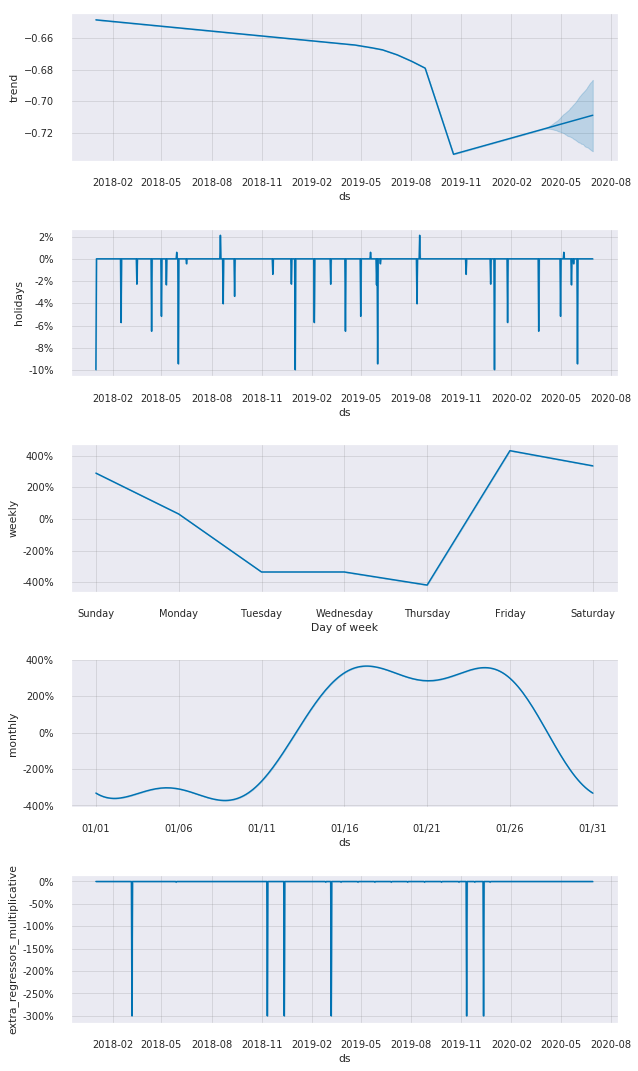

In [283]:
fig2 = m.plot_components(forecast)

In [284]:
df_customers = df_customers.merge(forecast, how='left', on='ds')

In [285]:
df_customers['rmse'] = (df_customers['yhat']-df_customers['y'])**2
df_customers['signed_rmse'] = df_customers.apply(lambda row: (row['yhat']-row['y'])**2 if (row['yhat'] > row['y']) else -(row['yhat']-row['y'])**2, axis=1)

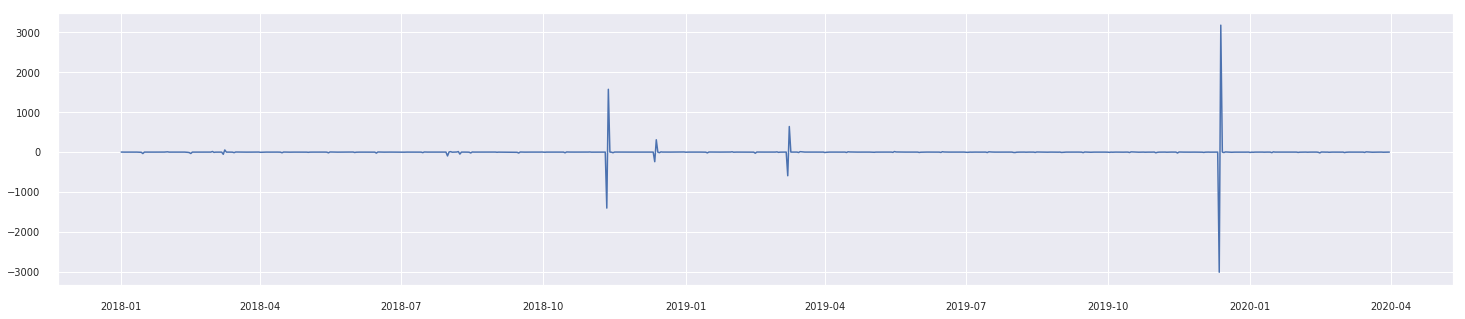

In [287]:
plt.figure(figsize=(25, 5))
plt.plot(df_customers['ds'], df_customers['signed_rmse'])

# Lollipop (moneymoji) Campaign
#plt.axvspan(datetime.strptime('2018-05-27', '%Y-%m-%d'), datetime.datetime.strptime('2018-07-07', '%Y-%m-%d'), facecolor='#7a5c58', alpha=0.5)

# Travel (Jalan2) Jenius
#plt.axvspan(datetime.strptime('2018-10-17', '%Y-%m-%d'), datetime.datetime.strptime('2018-12-21', '%Y-%m-%d'), facecolor='#99b2dd', alpha=0.5)
#plt.axvspan(datetime.strptime('2018-12-22', '%Y-%m-%d'), datetime.datetime.strptime('2019-01-15', '%Y-%m-%d'), facecolor='#b4869f', alpha=0.5)

# Mimpi2 Jenius
#plt.axvspan(datetime.strptime('2018-12-18', '%Y-%m-%d'), datetime.datetime.strptime('2019-01-31', '%Y-%m-%d'), facecolor='#9dfff9', alpha=0.5)

plt.show()

### LSTM
Inspired by [Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))

dataset = df_balance['change'].astype(float).values.reshape(-1, 1)
dataset = scaler.fit_transform(dataset)

In [ ]:
dataset[:5]

Splitting the data to train and test set

In [ ]:
train_split = 2/3
train_set_size = int(len(dataset) * train_split)
test_set_size = len(dataset) - train_set_size

train, test = dataset[0:train_set_size, :], dataset[train_set_size:len(dataset), :]

In [ ]:
print('Length of the train set: {:,} ({:.2f}%)\nLength of the test set: {:,} ({:.2f}%)'.format(
    len(train),
    train_split*100,
    len(test),
    (1-train_split)*100
))

In [ ]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])

    return np.array(dataX), np.array(dataY)

In [ ]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(trainX, trainY, epochs=20, validation_split=0.25, batch_size=1, verbose=1)

In [ ]:
plt.figure(figsize=(15, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])

In [ ]:
train_score = np.sqrt(mean_squared_error(trainY[0], train_predict[:,0]))
test_score = np.sqrt(mean_squared_error(testY[0], test_predict[:,0]))

print('Train Score: {:,.2f} RMSE\nTest Score: {:,.2f} RMSE'.format(
    train_score,
    test_score
))

In [ ]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure(1, figsize=(25, 6))
plt.plot(scaler.inverse_transform(dataset), label='Original')
plt.plot(trainPredictPlot, label='Train prediction')
plt.plot(testPredictPlot, label='Test prediction')
plt.legend()
plt.title('Prediction of total balance change')
plt.show()

In [ ]:
def restore_values_and_plot(change_series, first_value, title):
    df_plot = pd.DataFrame(data={'change': change_series, 'yhat': first_value})
    df_plot.dropna(subset=['change'], how='any', inplace=True)
    df_plot.reset_index(drop=False, inplace=True)

    for i in range(1, len(df_plot)):
        df_plot.loc[i, 'yhat'] = df_plot.loc[i-1, 'yhat'] + df_plot.loc[i, 'change']

    # Plot
    plt.figure(figsize=(25, 5))
    ax = plt.gca()
    ax.get_yaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )

    plt.title(title)
    plt.plot(df_plot.index, df_plot['yhat'], label='Total balance')
    plt.xticks(rotation = 15)
    plt.legend(loc='upper left')
    plt.show()

restore_values_and_plot(testPredictPlot.flatten(), df_balance.loc[0, 'balance'], 'Prediction of total balance')

## Input data generator

In [248]:
amount_limits = [2000, 2200]
period = ['2018-01-01', '2020-04-01']
column_names = ['date', 'amount']
number_of_change_points = np.random.randint(2, 4)

weekly_deviation_random = [50, 75]
monthly_deviation_random = [100, 150]
holiday_extra_percentage = 0.05

add_error = 1500 # False or a number

In [249]:
change_point_datetimes = []
change_point_values = []

print('Number of change points: {:}'.format(number_of_change_points))

days_difference = (datetime.strptime(period[-1], '%Y-%m-%d') - datetime.strptime(period[0], '%Y-%m-%d')).days
period_day_difference = int(days_difference/number_of_change_points)
print('Total length of output dataframe: {:}\nPeriod length in days: {:}\n'.format(
    days_difference,
    period_day_difference
))

df_output = pd.DataFrame(0, index=np.arange(days_difference), columns=column_names)

for i in range(number_of_change_points):
    change_point_datetimes.append(
        datetime.strptime(period[0], '%Y-%m-%d') +
        (datetime.strptime(period[1], '%Y-%m-%d') - datetime.strptime(period[0], '%Y-%m-%d'))/number_of_change_points*i
    )

change_point_datetimes.append(
    datetime.strptime(period[-1], '%Y-%m-%d')
)

for i in range(number_of_change_points+1):
    change_point_values.append(np.random.randint(amount_limits[0], amount_limits[1]))
    print('Change point {:}.\n- Date: {:}\n- Value: {:}\n'.format(
        i+1,
        change_point_datetimes[i].strftime("%Y-%m-%d"),
        change_point_values[-1]
    ))

    df_output.loc[i*period_day_difference, column_names[0]] = change_point_datetimes[i]
    df_output.loc[i*period_day_difference, column_names[1]] = change_point_values[-1]

j = 0
for i in range(1, days_difference):
    if change_point_datetimes[j+1] < df_output.loc[i-1, column_names[0]]:
        j+= 1

    current_delta = (change_point_values[j+1]-change_point_values[j])/period_day_difference

    df_output.loc[i, column_names[0]] = df_output.loc[i-1, column_names[0]] + timedelta(days=1)
    df_output.loc[i, column_names[1]] = df_output.loc[i-1, column_names[1]] + current_delta

df_output['date'] = pd.to_datetime(df_output['date'])

Number of change points: 3
Total length of output dataframe: 821
Period length in days: 273

Change point 1.
- Date: 2018-01-01
- Value: 2115

Change point 2.
- Date: 2018-10-01
- Value: 2134

Change point 3.
- Date: 2019-07-02
- Value: 2015

Change point 4.
- Date: 2020-04-01
- Value: 2034



In [250]:
df_output['day'] = df_output['date'].dt.day
df_output['month_weight'] = df_output['day'].apply(lambda x: x if x < 15 else 31-x)
df_output['amount_monthly'] = df_output['amount']*(1 + (df_output['month_weight']+np.random.randint(monthly_deviation_random[0], monthly_deviation_random[1]))/1000)

In [251]:
df_output['dow'] = df_output[column_names[0]].dt.dayofweek
df_output['week_weight'] = df_output['dow'].apply(lambda x: x if x < 4 else 6-x)
df_output['amount_weekly'] = df_output['amount_monthly']*(1 + (df_output['week_weight']+np.random.randint(weekly_deviation_random[0], weekly_deviation_random[1]))/1000)

In [252]:
holidays = ['2018-03-08', '2018-11-11', '2018-12-12', '2019-03-08', '2019-11-11', '2019-12-12']
for i in holidays:
    df_output.loc[
        df_output[df_output[column_names[0]] == i].index,
        'amount_weekly'
    ] = (1 + (holiday_extra_percentage*np.random.randint(0, 100))/100)*df_output['amount_weekly']

In [253]:
if add_error:
    start = int(days_difference*np.random.uniform(0, 1))
    end = start + np.random.randint(2, 10)
    print('Adding error between {:} and {:}'.format(
        df_output.loc[start, 'date'],
        df_output.loc[end, 'date']
    ))

    df_output.loc[start:end, 'amount_weekly'] = add_error

Adding error between 2018-08-01 00:00:00 and 2018-08-06 00:00:00


In [254]:
df_output['amount_ma3'] = df_output['amount_weekly'].rolling(window=3).mean()

In [255]:
df_output[start-1:end+1]

,date,amount,day,month_weight,amount_monthly,dow,week_weight,amount_weekly,amount_ma3
211,2018-07-31,2129.684982,31,0,2346.912850,1,1,2487.727621,2488.337005
212,2018-08-01,2129.754579,1,1,2349.119300,2,2,1500.000000,2158.427457
213,2018-08-02,2129.824176,2,2,2351.325890,3,3,1500.000000,1829.242540
214,2018-08-03,2129.893773,3,3,2353.532619,4,2,1500.000000,1500.000000
215,2018-08-04,2129.963370,4,4,2355.739487,5,1,1500.000000,1500.000000
216,2018-08-05,2130.032967,5,5,2357.946495,6,0,1500.000000,1500.000000
217,2018-08-06,2130.102564,6,6,2360.153641,0,0,1500.000000,1500.000000


In [256]:
df_output[:10]

,date,amount,day,month_weight,amount_monthly,dow,week_weight,amount_weekly,amount_ma3
0,2018-01-01,2115.000000,1,1,2332.845000,0,0,2470.482855,NaN
1,2018-01-02,2115.069597,2,2,2335.036835,1,1,2475.139045,NaN
2,2018-01-03,2115.139194,3,3,2337.228810,2,2,2479.799767,2475.140556
3,2018-01-04,2115.208791,4,4,2339.420923,3,3,2484.465020,2479.801277
4,2018-01-05,2115.278388,5,5,2341.613176,4,2,2484.451580,2482.905456
5,2018-01-06,2115.347985,6,6,2343.805568,5,1,2484.433902,2484.450167
6,2018-01-07,2115.417582,7,7,2345.998099,6,0,2484.411987,2484.432489
7,2018-01-08,2115.487179,8,8,2348.190769,0,0,2486.734025,2485.193304
8,2018-01-09,2115.556777,9,9,2350.383579,1,1,2491.406593,2487.517535
9,2018-01-10,2115.626374,10,10,2352.576527,2,2,2496.083696,2491.408105


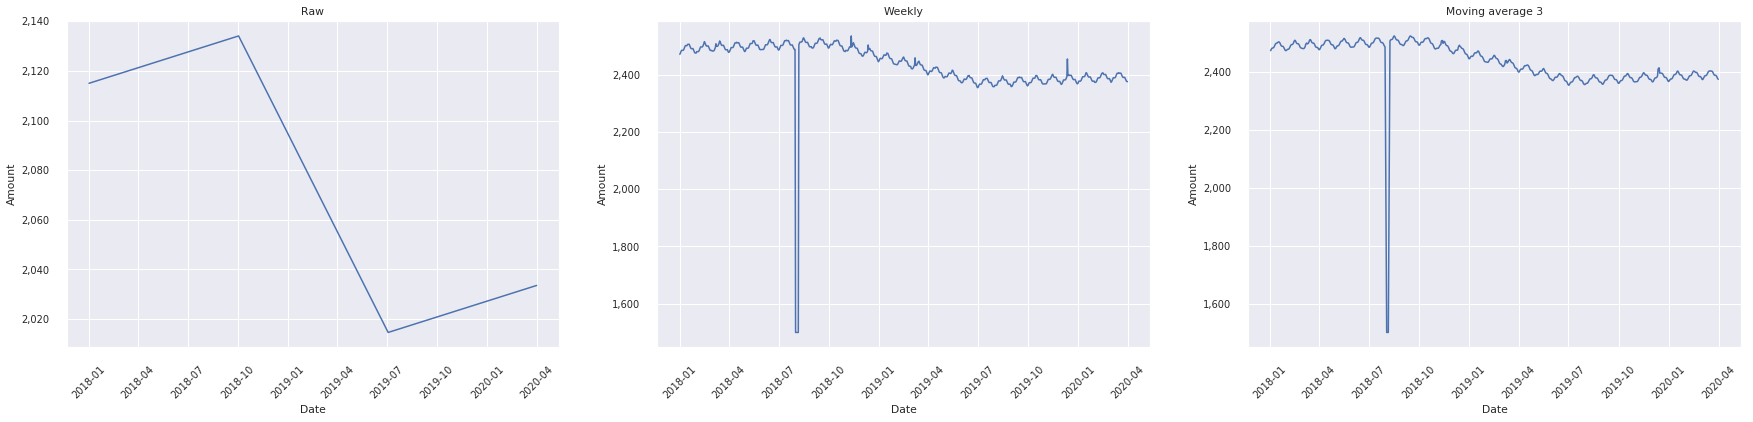

In [257]:
plt.figure(figsize=(30, 6))
sns.set(font_scale=0.9)

plt.subplot(1, 3, 1)
ax = sns.lineplot(x=df_output['date'], y=df_output['amount'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Amount')
ax.set_title('Raw')

plt.subplot(1, 3, 2)
ax = sns.lineplot(x=df_output['date'], y=df_output['amount_weekly'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Amount')
ax.set_title('Weekly')

plt.subplot(1, 3, 3)
ax = sns.lineplot(x=df_output['date'], y=df_output['amount_ma3'], markers = True, dashes = False)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
plt.xticks(rotation = 45)
plt.xlabel('Date')
plt.ylabel('Amount')
ax.set_title('Moving average 3')

plt.show()

In [258]:
filename = 'data/output_{:}.csv'.format(datetime.now().strftime("%Y%m%d%H%M%S"))
df_output[['date', 'amount_weekly']].to_csv(filename, index=False)
print('`' + str(filename) + '` saved')

`data/output_20200426214825.csv` saved
